In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from cycle_detection import detect_respiration_cycles
from respiration_features import get_all_respiration_features
from params import patient, respi_chan, srate , rsp_detect_sign
import ghibtools as gh
%matplotlib widget

## LOAD 

In [3]:
patient

'P1'

In [4]:
save = False

In [5]:
da = xr.load_dataarray(f'../dataarray/da_N2N3_{patient}.nc').sel(chan = respi_chan)

## TOOLS

In [6]:
def rsp_cycle_detection(resp_sig, srate=srate):

    cycles = detect_respiration_cycles(resp_sig, sampling_rate=srate, t_start = 0., output = 'index',

                                    # preprocessing
                                    inspiration_sign = '+',
                                    high_pass_filter = None,
                                    constrain_frequency = None,
                                    median_windows_filter = None,

                                    # baseline
                                    baseline_with_average = True,
                                    manual_baseline = 0.,

                                    # clean
                                    eliminate_time_shortest_ratio = 2,
                                    eliminate_amplitude_shortest_ratio = 10,
                                    eliminate_mode = 'OR', # 'AND'

                                    )

    return cycles

## CYCLE DETECTION

In [7]:
rsp = da.values
t = da.coords['time'].values
cycles = rsp_cycle_detection(rsp)
inspis = cycles[:,0]
expis = cycles[:,1]

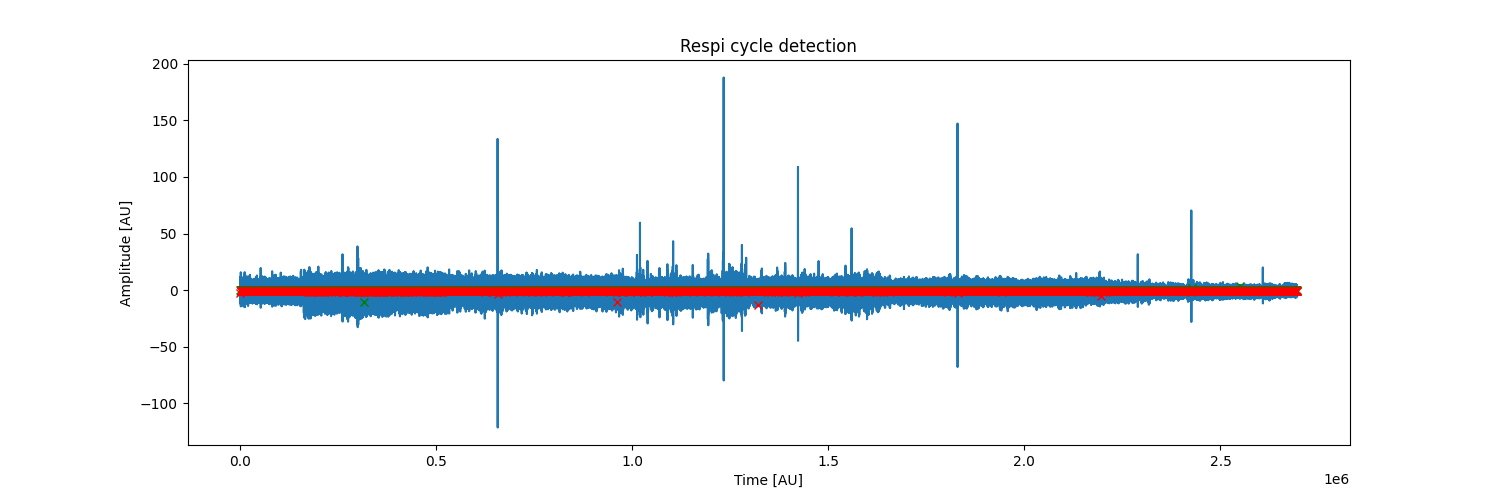

In [8]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(rsp)
ax.plot(inspis, rsp[inspis], 'x', color = 'g')
ax.plot(expis, rsp[expis], 'x', color = 'r')
ax.set_title(f'Respi cycle detection')
ax.set_ylabel('Amplitude [AU]')
ax.set_xlabel('Time [AU]')
plt.show()

## RESP FEATURES FROM CYCLES & RESP

In [9]:
duration_min=1.5
duration_max = 20
inspi_min=0.5
inspi_max=10

In [10]:
resp_features = get_all_respiration_features(resp_sig=rsp, sampling_rate=srate, cycles=cycles, t_start = 0.)
resp_features.insert(0, 'participant',patient)
initial_n_cycles = resp_features.shape[0]
clean_cycles = []
for i , cycle in resp_features.iterrows():
    if cycle['cycle_duration'] > duration_min and cycle['cycle_duration'] < duration_max and cycle['insp_duration'] > inspi_min and cycle['insp_duration'] < inspi_max and cycle['exp_duration'] > inspi_min and cycle['exp_duration'] < inspi_max:
        clean_cycles.append(cycle)

df_return = pd.concat(clean_cycles, axis = 1).T

print(f'{initial_n_cycles - df_return.shape[0]} cycles removed')
if save:
    print('SAVING')
    df_return.to_excel(f'../df_analyse/resp_features_{patient}.xlsx')


/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'objec

4 cycles removed


In [11]:
resp_features[['cycle_duration','insp_duration','exp_duration','cycle_freq']].mean()

cycle_duration    2.887409
insp_duration     1.042586
exp_duration      1.844822
cycle_freq        0.349595
dtype: float64

In [16]:
df_return.reset_index(drop=True).iloc[880:895,:]

,participant,cycle_num,inspi_index,expi_index,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,cycle_freq,insp_volume,exp_volume,total_amplitude,insp_amplitude,exp_amplitude
880,P1,880,651278,651558,2544.054688,2545.148438,2.957031,1.09375,1.863281,0.338177,7.77547,-11.201889,26.780564,11.087138,15.693427
881,P1,881,652035,652297,2547.011719,2548.035156,2.707031,1.023438,1.683594,0.369408,6.635193,-9.339083,24.455858,10.590734,13.865124
882,P1,882,652728,652985,2549.71875,2550.722656,2.699219,1.003906,1.695312,0.370478,7.186445,-9.814636,24.918954,10.841542,14.077411
883,P1,883,653419,653705,2552.417969,2553.535156,2.972656,1.117188,1.855469,0.336399,8.195956,-11.270977,27.045895,11.896891,15.149004
884,P1,884,654180,654439,2555.390625,2556.402344,2.6875,1.011719,1.675781,0.372093,9.448972,-12.001637,32.917419,13.974771,18.942647
885,P1,885,654868,655149,2558.078125,2559.175781,4.042969,1.097656,2.945312,0.247343,7.627347,-12.745028,27.465709,11.273977,16.191732
886,P1,886,655903,656371,2562.121094,2563.949219,4.546875,1.828125,2.71875,0.219931,137.403391,-91.752362,255.0578,133.651211,121.406589
887,P1,887,657067,657230,2566.667969,2567.304688,2.304688,0.636719,1.667969,0.433898,4.947844,-7.111014,23.527961,13.180295,10.347666
888,P1,888,657657,657842,2568.972656,2569.695312,4.605469,0.722656,3.882812,0.217133,4.976601,-10.154887,23.351507,12.495731,10.855776
889,P1,890,659824,660011,2577.4375,2578.167969,2.914062,0.730469,2.183594,0.343164,2.053319,-5.186101,12.013503,5.503454,6.51005
